# Neural Networks

This notebook is to facilitate discussion on feedforward neural networks.

Literature:

Gu, Kelly, & Xiu. (2020) Empirical Asset Pricing via Machine Learning, The Review of Financial Studies, Volume 33, Issue 5, Pages 2223–2273, https://doi.org/10.1093/rfs/hhaa009


## Neural Networks (Part I: The Basics)

In [17]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import statsmodels.api as sm
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.utils import plot_model

np.random.seed(0)

%matplotlib inline

### **Step 1: Preparation**


In [18]:
# Define the parameters

In_Sample = 2520        # Approximate number of trading days in 10 years

Out_of_Sample = 126     # Approximate number of trading days in six months

In [19]:
def actual_vs_predicted_plot(actual, predicted, in_sample):
    """
    The actual_vs_predicted_plot function visualizes a comparison between actual values and predicted values.
    The plot considers both in-sample and out-of-sample observations
    """
    
    # Plot settings
    fig, ax = plt.subplots(figsize=(14, 7))
    plt.title('Actual vs Predicted Values')
    plt.xlabel('')
    plt.ylabel('')
    
    
    # Historical prices
    ax.plot(actual, color='black', label='Actual')
    ax.plot(predicted[:in_sample],
              color='Blue',
              label='Predicted (in-sample)')
    ax.plot(predicted[in_sample:],
              color='Red',
              label='Predicted (out-of-sample)')
    
    # plt.legend()
    plt.tight_layout()
    plt

In [20]:
def r_squared_score(actual, predicted):
    
    """
    Calculate and print the R2 score between actual and predicted values.
    """

    r_squared = r2_score(actual, predicted)

    print(f"R-squared value: {r_squared}")

### **Step 2: Generate the data**

The data set (initially) represents a simple linear relationship (e.g., y = 2x + 1), which is split into training and test sets.

In [21]:
# Sample Data: 
# Start with a simple linear relationship (y = 2x + 1)
# Then consider a non-linear relationship (y = 2x**2 + 1)

X = np.random.rand(In_Sample+Out_of_Sample, 1)  # 100 samples, 1 feature
y = 2 * X + 1

# Create a DataFrame
df = pd.DataFrame({
    'X': X.flatten(),
    'y': y.flatten()
})

df_train = df[:In_Sample]
df_test = df[In_Sample:]

df

,X,y
0,0.548814,2.097627
1,0.715189,2.430379
2,0.602763,2.205527
3,0.544883,2.089766
4,0.423655,1.847310
...,...,...
2641,0.953706,2.907412
2642,0.795253,2.590506
2643,0.389786,1.779573
2644,0.584291,2.168583


### **Step 3: The Regression Model**

Our benchmark model is the lineear regression model estimated with OLS.

The model is available from the statsmodels package.
This can also be done in sklearn following the textbook.

In [22]:
indep_var = ['X']

# Assuming df_train['y'] is your dependent variable and df_train['x'] your independent variable
y = df_train['y']

# Add a constant to the model (for the intercept)
X = sm.add_constant(df_train[indep_var])

# Fit the model
# Make sure the dependent variable (y) is the first argument
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.193e+33
Date:                Mon, 24 Mar 2025   Prob (F-statistic):               0.00
Time:                        11:03:28   Log-Likelihood:                 85944.
No. Observations:                2520   AIC:                        -1.719e+05
Df Residuals:                    2518   BIC:                        -1.719e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0000   1.48e-17   6.75e+16      0.0

**Assessing the accuracy of the model**

R-squared value: 1.0


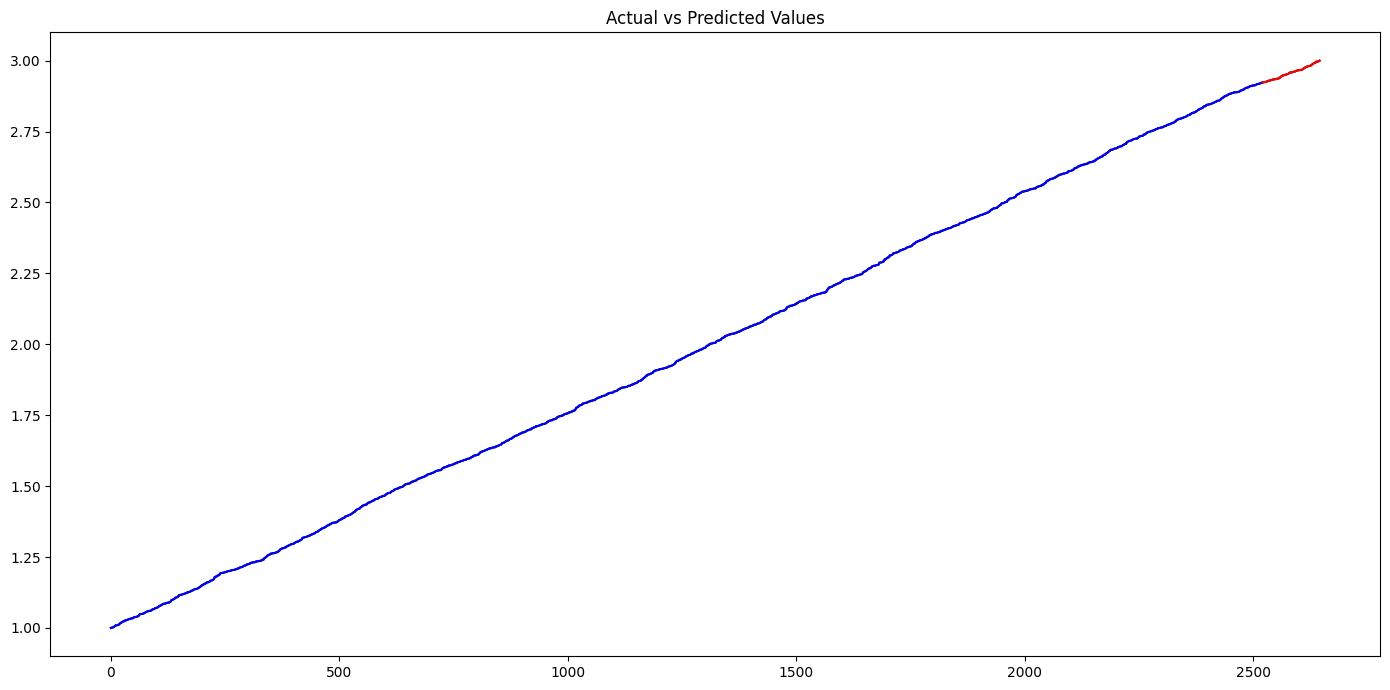

In [23]:
y_pred = model.predict(sm.add_constant(df[indep_var]))

df_reg = pd.DataFrame({
    'obs': df['y'],
    'pred': y_pred
})
df_reg = df_reg.sort_values(by=['obs']).reset_index()

actual_vs_predicted_plot(df_reg['obs'], df_reg['pred'], In_Sample)

y_pred_oos = model.predict(sm.add_constant(df_test[indep_var]))
r_squared_score(df_test[['y']], y_pred_oos)

### **Step 4: The Neural Network Model**

We'll begin by defining a simple neural network with one unit and a linear activation function, using the Tensorflow Keras package.

In [24]:
def neural_netork(input_dim):
  model = Sequential()

  # A single Dense layer (perceptron) with 1 unit and a linear activation function
  model.add(Dense(1, input_shape=(input_dim,), activation='linear'))

  # Compile the model
  # The optimizer is set to 'adam', and the loss function to 'mean_squared_error'
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                loss='mean_squared_error'
                )

  # Summary of the model to see its structure
  print(model.summary())

  return model

In [25]:
# Train the model
# Using df_train['x'] as input and df_train['y'] as the target

indep_var = ['X']

model = neural_netork(len(indep_var))
history = model.fit(df_train[indep_var].values, df_train['y'].values,
                    epochs=10,
                    batch_size=16,
                    validation_split=0,
                    verbose=0,
                    shuffle=False
                    )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [26]:
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [27]:
# Print the weights and biases

"""
This code iterates through each layer of a model, retrieves and prints the weights and biases for every layer,
specifying each layer's position in the sequence.
"""

for layer in model.layers:
    weights, biases = layer.get_weights()
    print(f"Weights of layer {model.layers.index(layer)+1}: {weights}")
    print(f"Biases of layer {model.layers.index(layer)+1}: {biases}")

Weights of layer 1: [[2.000111]]
Biases of layer 1: [0.9999372]


4/4 [==============================] - 0s 2ms/step
R-squared value: 1.0


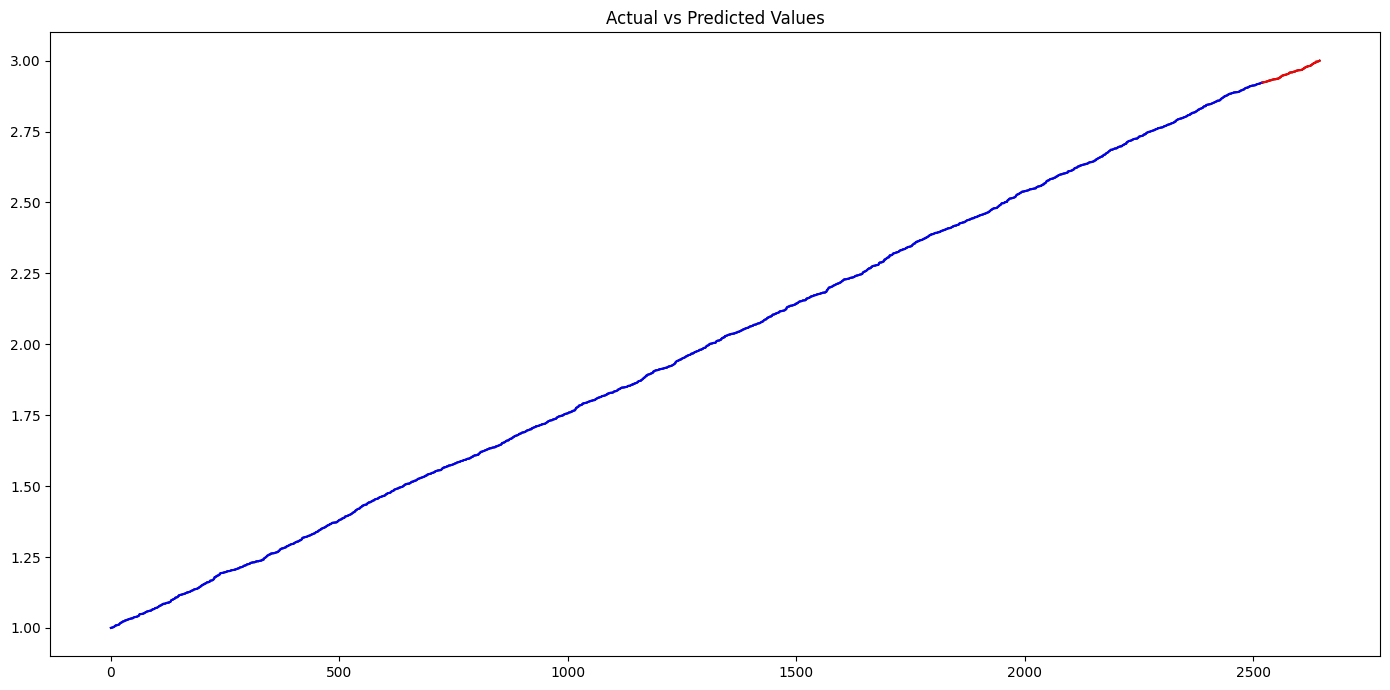

In [28]:
# Generate predictions
y_pred = pd.Series(model.predict(df[indep_var]).flatten())  # Flatten is used to ensure the prediction array shape matches the target array
y_pred.index = df.index


df_reg = pd.DataFrame({
    'obs': df['y'],
    'pred': y_pred
})
df_reg = df_reg.sort_values(by=['obs']).reset_index()

actual_vs_predicted_plot(df_reg['obs'], df_reg['pred'], In_Sample)


y_pred_oos = pd.Series(model.predict(df_test[indep_var]).flatten())
y_pred_oos.index = df_test.index

r_squared_score(df_test[['y']], y_pred_oos)

### **To Do**

1) Run both OLS regression and NN model replicating linear regression.

2) Then consider the Universal Approximation Theorem: 
Multilayer feed-forward networks with as few as one hidden layer are universal approximators.

Add a hidden layer to the NN. The assess if we can fit both the linear and non-linear function.
   - First try with linear activation functions
   - Then try with non-linear (ReLU) activation.

Does the depth and width of the network matter? Let's check.


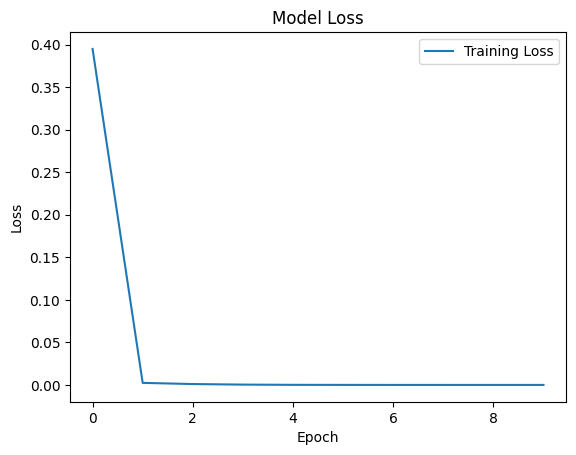

In [29]:
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()